## Dataset preprocessing



In [2]:
import numpy as nb
import pandas as pd

from sklearn import preprocessing
from sklearn import decomposition
from sklearn.preprocessing import MinMaxScaler

from matplotlib import pyplot as plt

%matplotlib inline

import datetime

### Timestamp extraction

Because crazy things happened in the past year,  we validated that, some specific dates had significantly higher electricity prices. Therefore we do weekday, month, and time extraction from the timestamp.  



In [3]:
def extract_weekday(dataset):
    splits = dataset['date'].astype(str).str.split('-')
    dataset['weekday'] = [datetime.date(int(year), int(month), int(day)).weekday() for (year, month, day) in splits]

In [4]:
def extract_month(dataset):
    dataset['month'] = [month for (_, month, _) in dataset['date'].astype(str).str.split('-')]

In [5]:
def extract_datetime(dataset):
    dataset.loc[:,'time'] = pd.to_datetime(dataset.loc[:,'time'], format="%Y-%m-%d %H:%M:%S", utc=True)
    dataset['date'] = dataset['time'].dt.date
    dataset['hour'] = dataset['time'].dt.hour

In [6]:
def one_hot_encode(dataset, columns, encoder = None) -> preprocessing.OneHotEncoder:
    if encoder:
        transformed = encoder.transform(dataset[columns])
    else:
        encoder = preprocessing.OneHotEncoder(sparse= False)
        transformed = encoder.fit_transform(dataset[columns])

    new_columns = []
    for i, column in enumerate(encoder.feature_names_in_):
        new_columns.extend([column + str(cat) for cat in encoder.categories_[i]])

    encoder_df = pd.DataFrame(transformed, index=dataset.index)
    dataset[new_columns] = encoder_df
    dataset.drop(columns=columns, inplace=True)
    return encoder

In [7]:
def extract_features(dataset):
    extract_datetime(dataset)
    extract_month(dataset)
    extract_weekday(dataset)


### Feature dropping

In Estonia, there are approximately 500\-800 millimeters of rain on average. Our dataset consisted of only about 140mm of rain, which is definitely not correct. Also, the amount of snow was inappropriate for the  
 same reason.


In [8]:
def drop_features(dataset):
    dataset.drop(columns=['snow','prcp','time','date'], inplace=True)


In [9]:
def drop_rows(dataset):
    # Deal with NaN values
    initial_len = len(dataset)
    dataset.dropna(inplace=True)
    new_len = len(dataset)
    if (initial_len != new_len):
        print(f'Dropped {initial_len - new_len} row')

    # Deal with outliners
    dataset.drop(dataset[dataset['el_price'] > 1].index , inplace=True)

In [10]:
def normalize(dataset, scaler = None) -> (pd.DataFrame, preprocessing.MinMaxScaler):
    if scaler:
        dataset_scaled = scaler.transform(dataset)
        return (dataset_scaled, scaler)
    scaler = preprocessing.MinMaxScaler()
    dataset_scaled = scaler.fit_transform(dataset)
    return (dataset_scaled, scaler)

In [11]:
def reduce_dimensions(dataset, pca = None) -> (pd.DataFrame, decomposition.PCA):
    if pca:
        dataset_reduced = pca.transform(dataset)
        return (dataset_reduced, pca)
    pca = decomposition.PCA(n_components=0.9)
    dataset_reduced = pca.fit_transform(dataset)
    return (dataset_reduced, pca)

In [12]:
def preprocess(dataset, encoder=None) -> preprocessing.OneHotEncoder:
    extract_features(dataset)
    drop_features(dataset)
    encoder = one_hot_encode(dataset, ['coco', 'weekday'], encoder)
    drop_rows(dataset)
    return encoder


### Import dataset

Here we import dataset, do inital processing and split into train and validation.

In [13]:
def read_dataset(file_name) -> pd.DataFrame:
    return pd.read_csv(file_name)

In [14]:
def extract_labels(dataset) -> (pd.DataFrame, pd.Series):
    X_train = dataset.loc[:, ~dataset.columns.isin(['consumption'])]
    y_train = dataset['consumption']
    return (X_train, y_train)

In [15]:
train_df = read_dataset('train.csv')
encoder = preprocess(train_df)


X_train, y_train = extract_labels(train_df)

X_train_norm, scaler = normalize(X_train)
X_train_reduced, pca = reduce_dimensions(X_train_norm)


Dropped 2 row


In [16]:
X_train_norm.shape

(8588, 41)

In [17]:
X_test = read_dataset('test.csv')
preprocess(X_test, encoder)

X_test_norm, _ = normalize(X_test, scaler)
print(X_test_norm.shape)
X_test_reduced, _ = reduce_dimensions(X_test_norm, pca)

(168, 41)


In [18]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X_train_reduced, y_train, test_size=0.2)

In [19]:
X_train.shape

(6870, 16)

In [25]:
import itertools

# Numpy
import numpy as np

# Keras
from keras.layers import Dense, Input, BatchNormalization
from keras.models import Sequential
from tensorflow.keras.optimizers import SGD

# Pandas
import pandas as pd

# Sklearn
import sklearn.preprocessing
import sklearn.utils

# Visualiseerimine
import matplotlib.pyplot as plt
%matplotlib inline

In [48]:
from tensorflow.keras.layers import Input, Conv2D, Activation, Flatten, Dense, MaxPooling2D, BatchNormalization, Dropout

mdl = Sequential()

mdl.add(Dense(2056, activation="relu", input_shape=(X_train.shape[1],)))
mdl.add(BatchNormalization())
mdl.add(Dropout(0.2))
mdl.add(Dense(1028, activation="relu"))
mdl.add(Dropout(0.2))
mdl.add(BatchNormalization())
mdl.add(Dense(512, activation="relu"))
mdl.add(Dropout(0.2))
mdl.add(BatchNormalization())
mdl.add(Dense(64, activation="relu"))
mdl.add(BatchNormalization())
mdl.add(Dense(32, activation="relu"))
mdl.add(Dropout(0.2))
mdl.add(Dense(1, activation="relu"))

mdl.compile(loss='mean_squared_error', optimizer="adam")

In [49]:
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)
print(X_test_reduced.shape)

(6870, 16)
(6870,)
(1718, 16)
(1718,)
(168, 16)


In [50]:
history = mdl.fit(X_train, y_train, validation_data=(X_val,y_val), epochs=20, batch_size=32, verbose=True)

Epoch 1/20
215/215 [==============================] - 5s 20ms/step - loss: 1.6208 - val_loss: 1.1426
Epoch 2/20
215/215 [==============================] - 4s 19ms/step - loss: 1.3435 - val_loss: 1.1319
Epoch 3/20
215/215 [==============================] - 4s 19ms/step - loss: 1.2125 - val_loss: 1.0909
Epoch 4/20
215/215 [==============================] - 4s 19ms/step - loss: 1.1499 - val_loss: 1.0394
Epoch 5/20
215/215 [==============================] - 4s 19ms/step - loss: 1.1070 - val_loss: 1.0718
Epoch 6/20
215/215 [==============================] - 4s 19ms/step - loss: 1.0884 - val_loss: 1.0211
Epoch 7/20
215/215 [==============================] - 4s 19ms/step - loss: 1.0595 - val_loss: 1.0284
Epoch 8/20
215/215 [==============================] - 4s 20ms/step - loss: 1.0341 - val_loss: 1.0216
Epoch 9/20
215/215 [==============================] - 4s 19ms/step - loss: 1.0274 - val_loss: 1.0133
Epoch 10/20
215/215 [==============================] - 4s 20ms/step - loss: 1.0012 - val_lo

Text(0.5, 1.0, 'Loss')

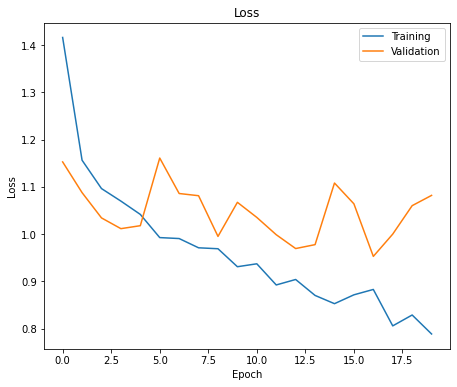

In [47]:
plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Training', 'Validation'])
plt.title('Loss')

#plt.subplot(1, 2, 2)
#plt.plot(history.history['accuracy'])
#plt.plot(history.history['val_accuracy'])
#plt.xlabel('Epoch')
#plt.ylabel('Accuracy')
#plt.legend(['Training', 'Validation'])
#plt.title('Accuracy')

In [ ]:
prediction = mdl.predict(X_test_reduced)

6/6 [==============================] - 0s 4ms/step


In [ ]:
prediction

array([[ 0.55791247],
       [ 0.98776937],
       [ 0.55447257],
       [ 0.37025332],
       [ 0.35828894],
       [ 0.47090366],
       [ 0.3281689 ],
       [ 0.31068227],
       [ 0.2926287 ],
       [ 0.37350696],
       [ 0.6460501 ],
       [ 0.30070207],
       [ 0.23358694],
       [-0.0598436 ],
       [ 0.03840408],
       [ 0.19357336],
       [ 0.4687493 ],
       [ 0.6466615 ],
       [ 1.1371083 ],
       [ 1.2468561 ],
       [ 1.0559766 ],
       [ 1.0507045 ],
       [ 0.739915  ],
       [ 0.65002286],
       [ 0.89643455],
       [ 0.7540313 ],
       [ 0.7900305 ],
       [ 0.8366499 ],
       [ 0.52184796],
       [ 0.47625214],
       [ 0.5043218 ],
       [ 0.28834414],
       [ 0.25789073],
       [ 0.2238633 ],
       [ 0.6610346 ],
       [ 0.6948978 ],
       [ 0.72665846],
       [ 0.2740826 ],
       [ 0.8250036 ],
       [ 0.8235475 ],
       [ 0.97629917],
       [ 1.0396886 ],
       [ 1.0073481 ],
       [ 0.95737386],
       [ 0.80611336],
       [ 0

In [ ]:
X_test = read_dataset('test.csv')

In [ ]:
predictions_dict = {'time':X_test.time,'consumption':[el[0]for el in prediction]}
pred_df = pd.DataFrame(predictions_dict)
pred_df.to_csv('submission_291022_v1.csv',index=False)